In [27]:
import json
import matplotlib.pyplot as plt
import numpy as np

import sys  
sys.path.insert(1, 'funcs')
import ScalarField
import TangentPoint
import TangentPointSet

In [28]:
f = open("tangentmaps/breast_cancer.tmap","r")
dataImport = json.loads(f.read())
tmap = dataImport['tmap']
Col_labels = dataImport['Col_labels']

data = dataImport

# print(data['tmap'][0])
# print(data['Col_labels'])

In [29]:
# First pass: Create Point instances with any initial scale_factor (e.g., 1.0)
points = []
for tmap_entry in tmap:
    point = TangentPoint.TangentPoint(tmap_entry, 1.0, Col_labels)
    points.append(point)

# Collect all gradient vectors and positions from the Point instances
all_positions = np.array([point.position for point in points if point.valid])  # Shape: (M, 2)
all_gradient_vectors = np.vstack([point.gradient_vectors for point in points if point.valid])  # Shape: (total_num_vectors, 2)

# Compute maximum gradient vector length
gradient_lengths = np.linalg.norm(all_gradient_vectors, axis=1)
max_gradient_length = np.max(gradient_lengths)

# Compute position ranges
x_range = np.max(all_positions[:, 0]) - np.min(all_positions[:, 0])
y_range = np.max(all_positions[:, 1]) - np.min(all_positions[:, 1])
position_range = max(x_range, y_range)

# Decide on desired fraction of position range for maximum gradient length
desired_fraction = 0.05  # Adjust as necessary

# Compute scale factor
scale_factor = (position_range * desired_fraction) / max_gradient_length
print("Computed scale factor:", scale_factor)

# Update scale factor in each Point instance
for point in points:
    if point.valid:
        point.update_scale_factor(scale_factor)

Computed scale factor: 0.6178953731105454


# Vector Field

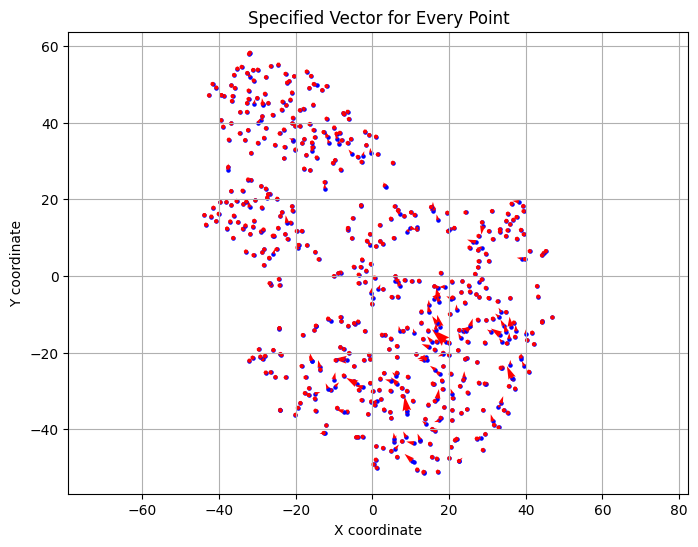

In [30]:
vector_index = 2

plt.figure(figsize=(8, 6))

for point in points:
    px, py = point.position[0], point.position[1]
    vx = point.gradient_vectors[vector_index][0]
    vy = point.gradient_vectors[vector_index][1]

    plt.scatter(px, py, color='blue', s=5)
    plt.quiver(px, py, vx, vy, angles='xy', scale_units='xy', scale=1, color='red')

plt.title("Specified Vector for Every Point")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.grid(True)
plt.axis('equal')
plt.show()

(569, 2)
(569, 2)


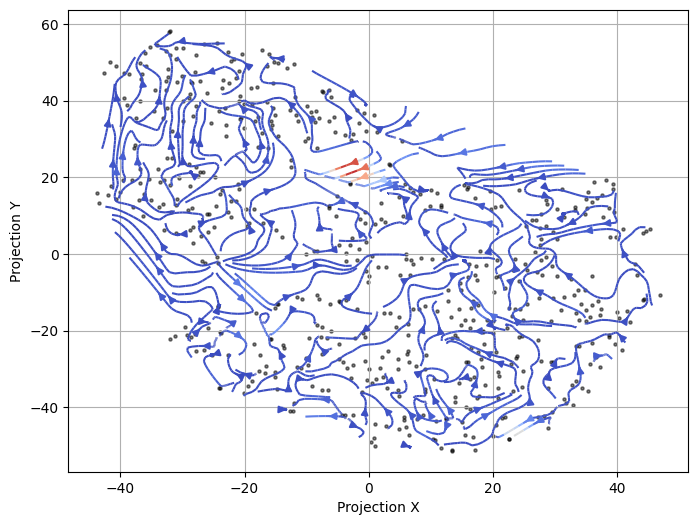

In [ ]:
from scipy.interpolate import griddata  # type: ignore

# Define a uniform grid
grid_x, grid_y = np.meshgrid(np.linspace(-80, 80, 500), np.linspace(-80, 80, 500))

gradient_list = []

for point in points:
    if point.valid:
        gradient_list.append(point.gradient_vectors[vector_index])

gradient_list = np.array(gradient_list)

# Interpolate feature vectors onto the grid using correct slicing
grid_gx = griddata((all_positions[:, 0], all_positions[:, 1]), gradient_list[:, 0], (grid_x, grid_y), method='cubic')
grid_gy = griddata((all_positions[:, 0], all_positions[:, 1]), gradient_list[:, 1], (grid_x, grid_y), method='cubic')

# Plot the feature map with streamlines
plt.figure(figsize=(8, 6))
plt.streamplot(grid_x, grid_y, grid_gx, grid_gy, density=5, color=np.hypot(grid_gx, grid_gy), cmap='coolwarm')
plt.scatter(all_positions[:, 0], all_positions[:, 1], c='black', s=5, alpha=0.5)
plt.grid(True)
plt.xlabel("Projection X")
plt.ylabel("Projection Y")
plt.show()

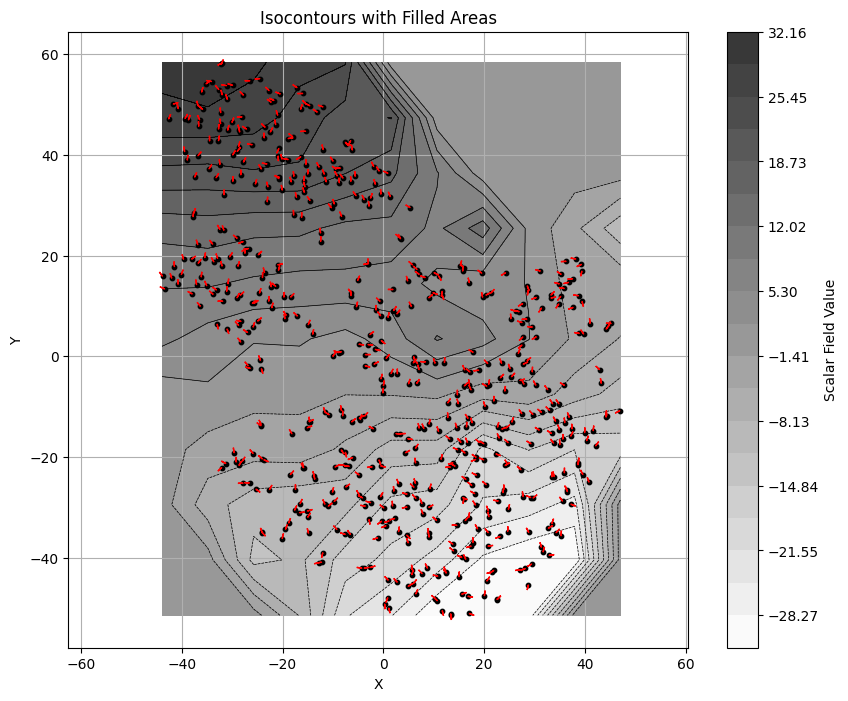

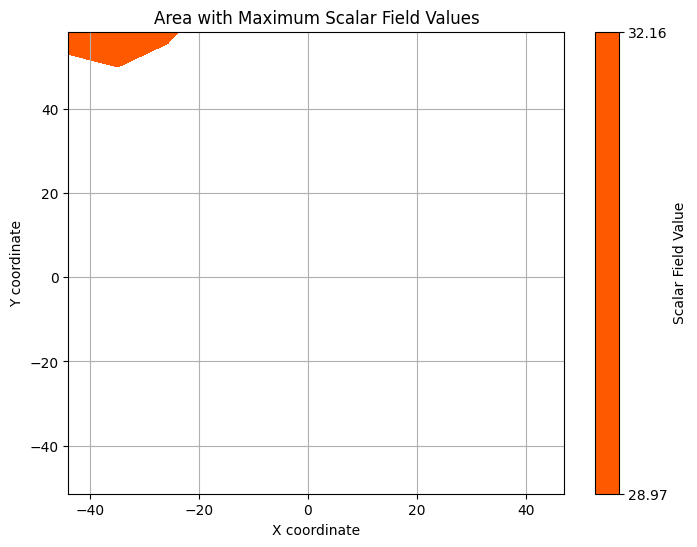

In [82]:
# Call the function with the points
feature_idx = 2
f_grid, X_grid, Y_grid, contour_levels = ScalarField.reconstruct_scalar_field(points, grid_size=10, feature_index=feature_idx)

fig, ax = plt.subplots(figsize=(10, 8))

# Create a colormap
cmap = plt.get_cmap('binary')

# Plot filled contours
contourf = ax.contourf(X_grid, Y_grid, f_grid, levels=contour_levels, cmap=cmap, alpha=0.8)

# Plot contour lines on top
contours = ax.contour(X_grid, Y_grid, f_grid, levels=contour_levels, colors='k', linewidths=0.5)

# Add a colorbar
cbar = fig.colorbar(contourf, ax=ax)
cbar.set_label('Scalar Field Value')

# Plot the point positions
positions = np.array([point.position for point in points if point.valid])
ax.scatter(positions[:, 0], positions[:, 1], c='black', s=10, zorder=5)

# Optionally plot the gradient vectors
for point in points:
    if point.valid:
        x, y = point.position
        # Using the same selected gradient as in the function
        gradients = point.gradient_vectors
        magnitudes = np.linalg.norm(gradients, axis=1)
        max_idx = np.argmax(magnitudes)
        gi = gradients[feature_idx]
        gi_norm = np.linalg.norm(gi)
        if gi_norm != 0:
            gi_unit = gi / gi_norm
        else:
            gi_unit = gi
        arrow_scale = 1
        ax.arrow(
            x, y,
            gi_unit[0] * arrow_scale, gi_unit[1] * arrow_scale,
            head_width=0.1,
            head_length=0.1,
            fc='red',
            ec='red',
            length_includes_head=True,
            zorder=6
        )

ax.set_title('Isocontours with Filled Areas')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.axis('equal')
plt.grid(True)
plt.show()

# Assume f_grid, X_grid, Y_grid, _ are obtained from reconstruct_scalar_field(...)
max_val = np.nanmax(f_grid)
min_val = np.nanmin(f_grid)
tolerance = 0.05 * (max_val - min_val)  # adjust 5% threshold as desired
threshold = max_val - tolerance

plt.figure(figsize=(8, 6))
plt.contourf(X_grid, Y_grid, f_grid, levels=[threshold, max_val], cmap='hot')
plt.colorbar(label="Scalar Field Value")
plt.title("Area with Maximum Scalar Field Values")
plt.xlabel("X coordinate")
plt.ylabel("Y coordinate")
plt.grid(True)
plt.show()

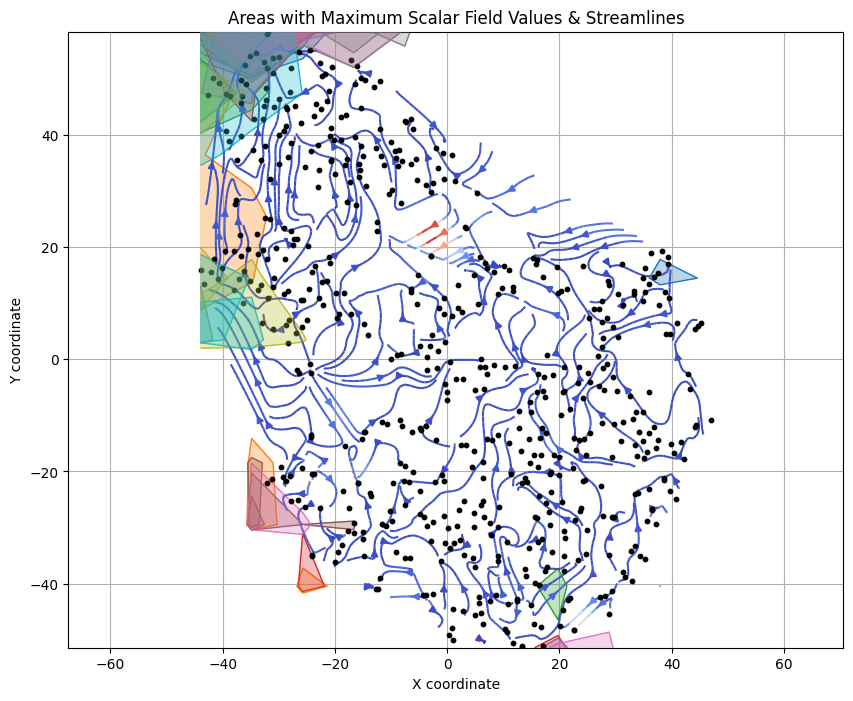

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

# === Reconstruct scalar fields for all features and plot high-value areas ===

feature_count = len(Col_labels)
colors = plt.cm.tab10(np.linspace(0, 1, feature_count))  # Discrete colors for each feature

fig, ax = plt.subplots(figsize=(10, 8))

for feature_idx in range(feature_count):
    # Reconstruct the scalar field for the current feature
    f_grid, X_grid, Y_grid, contour_levels = ScalarField.reconstruct_scalar_field(points, grid_size=10, feature_index=feature_idx)
    
    # Define threshold near the maximum value
    max_val = np.nanmax(f_grid)
    min_val = np.nanmin(f_grid)
    tolerance = 0.05 * (max_val - min_val)  # adjust tolerance as desired
    threshold = max_val - tolerance

    # Plot filled contour for regions with high values for the current feature
    ax.contourf(X_grid, Y_grid, f_grid, levels=[threshold, max_val], colors=[colors[feature_idx]], alpha=0.3, zorder=feature_idx)
    
    # Optionally display contour lines for the maximum region
    ax.contour(X_grid, Y_grid, f_grid, levels=[threshold, max_val], colors=[colors[feature_idx]], linewidths=1)

# Plot the underlying point positions for reference
positions = np.array([point.position for point in points if point.valid])
ax.scatter(positions[:, 0], positions[:, 1], c='black', s=10, zorder=20)

# === Compute streamlines and overlay on the same figure ===

# Assemble gradient vectors for the chosen index (cell 7 used vector_index = 2)
vector_index = 2
gradient_list = [point.gradient_vectors[vector_index] for point in points if point.valid]
gradient_list = np.array(gradient_list)

# Define uniform grid (choose appropriate limits; here using -80 to 80 as before)
grid_x, grid_y = np.meshgrid(np.linspace(-80, 80, 500), np.linspace(-80, 80, 500))

# Interpolate the gradient vectors onto the uniform grid
grid_gx = griddata((positions[:, 0], positions[:, 1]), gradient_list[:, 0], (grid_x, grid_y), method='cubic')
grid_gy = griddata((positions[:, 0], positions[:, 1]), gradient_list[:, 1], (grid_x, grid_y), method='cubic')

# Overlay streamlines
strm = ax.streamplot(grid_x, grid_y, grid_gx, grid_gy, density=5, color=np.hypot(grid_gx, grid_gy),
                     cmap='coolwarm', zorder=10)

ax.set_title('Areas with Maximum Scalar Field Values & Streamlines')
ax.set_xlabel('X coordinate')
ax.set_ylabel('Y coordinate')
ax.axis('equal')
plt.grid(True)
plt.show()